In [2]:
import numpy as np
import pandas as pd
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt 
import re
import demoji
demoji.download_codes()
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
import seaborn as sns


%matplotlib inline

... OK (Got response in 0.31 seconds)
Writing emoji data to /Users/anweshcr7/.demoji/codes.json ...
... OK


In [3]:
# conda install nltk
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /Users/anweshcr7/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/anweshcr7/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
# pip install libsvm

In [5]:
# some additional imports
# from autocorrect import speller
stopwordsList = stopwords.words('english')
# ended up lemmatizing instead of stemming
from nltk.stem import PorterStemmer
st = PorterStemmer()
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

In [6]:
def parse_dataset(fp):
    '''
    Loads the dataset file with label-tweet on each line and parses the dataset.
    :param fp: filepath of dataset
    :return:
        corpus: list of tweet strings of each tweet.
        y: list of labels
    '''
    y = []
    corpus = []
    with open(fp, 'rt') as data_in:
        for line in data_in:
            if not line.lower().startswith("tweet index"): # discard first line if it contains metadata
                line = line.rstrip() # remove trailing whitespace
                label = int(line.split("\t")[1])
                tweet = line.split("\t")[2]
                y.append(label)
                corpus.append(tweet)

    return corpus, y

In [7]:
data, y_label = parse_dataset('SemEval2018-T3-train-taskA_emoji.txt')
data_df = pd.DataFrame(np.array(data).reshape(3834,1), columns = ['tweet'])
data_df['label'] = np.array(y_label).reshape(3834,1)
data_df.loc[1][0]

"@mrdahl87 We are rumored to have talked to Erv's agent... and the Angels asked about Ed Escobar... that's hardly nothing    ;)"

In [8]:
data_df['tweet']
# data_df[ data_df['label'] == 1]

0       Sweet United Nations video. Just in time for C...
1       @mrdahl87 We are rumored to have talked to Erv...
2       Hey there! Nice to see you Minnesota/ND Winter...
3                     3 episodes left I'm dying over here
4       "I can't breathe!" was chosen as the most nota...
                              ...                        
3829    @banditelli regarding what the PSU president does
3830    @banditelli But still bothers me that I see no...
3831    well now that i've listened to all of into the...
3832    Hummingbirds #Are  #Experts #at #Hovering #Aft...
3833    Only thing missing now is a session at the gym...
Name: tweet, Length: 3834, dtype: object

In [9]:
def preprocess(tweet):

    clean_tweet = clean(tweet.lower())
    return clean_tweet

def preprocess(tweet):
#     Remove URL
    tweet = re.sub(r'http\S+', '', tweet)
#     remove hashtag (symbols) and punctuations
    punctuations = '''!()-![]{};:+'"\,<>./?@#$%^&*_~'''
    tweet = ''.join([i for i in tweet if not i in punctuations])
#     reomve emoji
    tweet = demoji.replace(tweet)
#     correct spellings if any
# Lemmatize over Stemming
    tweet = " ".join([wordnet_lemmatizer.lemmatize(word) for word in tweet.split()])
# Gives clean_tweet but now lets tokenize
# tokenize and remove stop-words
    tweet = word_tokenize(tweet)
    return ' '.join([word for word in tweet if word not in stopwordsList])

In [10]:
# Some feature engineering before pre-processing (might be useful!)
def preprocess_and_engineer(df):
    df['hashtag'] = data_df['tweet'].apply(lambda x: re.findall(r'\B#\w*[a-zA-Z]+\w*', x)) #creating a new column
    df['emoji'] = data_df['tweet'].apply(lambda x: demoji.findall(x)) #create a new emoji column
    df['clean_tweet'] = df['tweet'].apply(lambda x: preprocess(x))
#     del df['tweet']
    cols = ['clean_tweet', 'hashtag', 'emoji', 'label']
    return df[cols]

Positive words


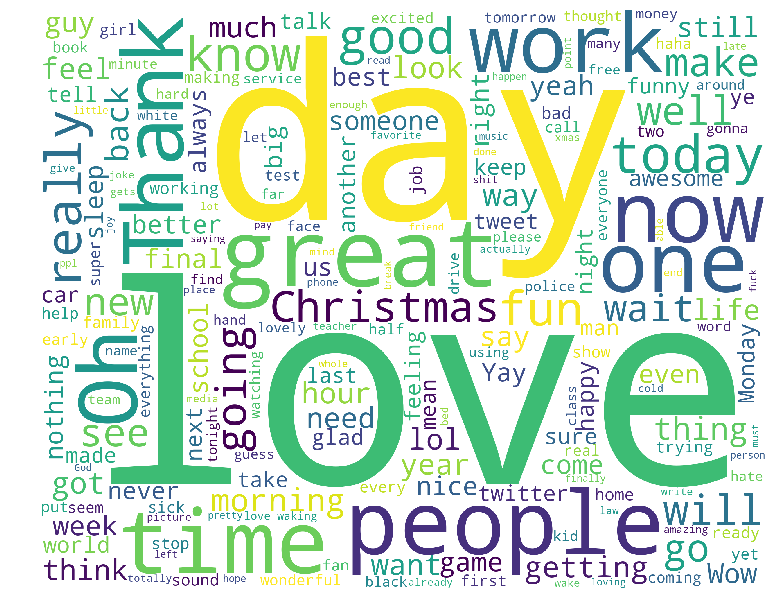

Negative words


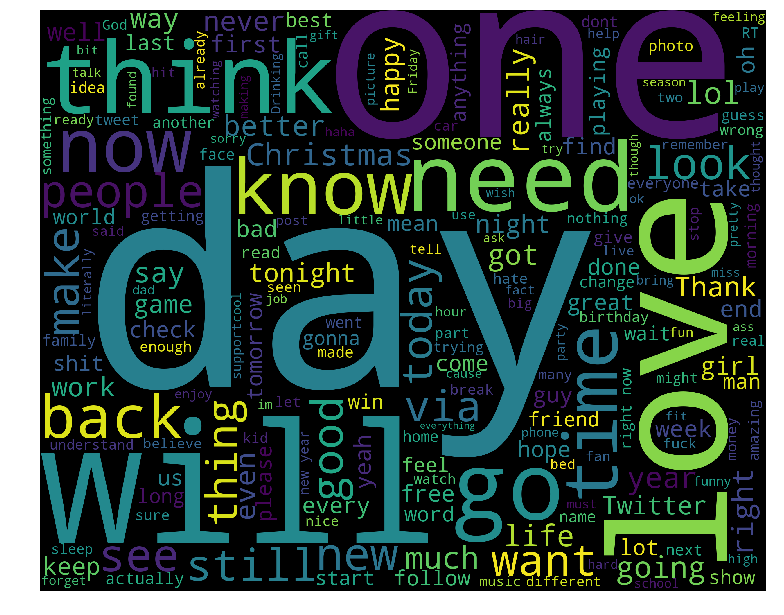

In [11]:
train_irony = data_df[ data_df['label'] == 1]
train_irony = train_irony['tweet']
train_normal = data_df[ data_df['label'] == 0]
train_normal = train_normal['tweet']

def wordcloud_draw(data, color = 'black'):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and not word.startswith('#')
                                and word != 'RT'
                            ])
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(cleaned_word)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
    
print("Positive words")
wordcloud_draw(train_irony,'white')
print("Negative words")
wordcloud_draw(train_normal)
# Doesn't seem to make a lot of difference!

In [133]:
clean_data_df = preprocess_and_engineer(data_df)
clean_data_df.head()

,clean_tweet,hashtag,emoji,label
0,Sweet United Nations video Just time Christmas...,"[#imagine, #NoReligion]",{},1
1,mrdahl87 We rumored talked Ervs agent Angels a...,[],{},1
2,Hey Nice see MinnesotaND Winter Weather,[],{},1
3,3 episode left Im dying,[],{},0
4,I cant breathe wa chosen notable quote year an...,[],{},1


In [134]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Returns a victorizer fitted with the training data
def vectorized_features(df):
    vectorizer = TfidfVectorizer(stop_words='english', sublinear_tf=True, strip_accents='unicode',
                                 analyzer='word', norm=None, ngram_range = (1,3))
    # tokenize and build vocab
    vectorizer.fit(df['clean_tweet'])
    return vectorizer

In [135]:
tweet_vectorizer = vectorized_features(clean_data_df)
tweet_vector = tweet_vectorizer.transform(clean_data_df['clean_tweet'])
tweet_vector

<3834x55217 sparse matrix of type '<class 'numpy.float64'>'
	with 73215 stored elements in Compressed Sparse Row format>

In [136]:
tweet_vector


<3834x55217 sparse matrix of type '<class 'numpy.float64'>'
	with 73215 stored elements in Compressed Sparse Row format>

In [137]:
# Training a Naive Bayes Implementation
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold
from sklearn import metrics

gnb = GaussianNB()
score = []
kfold = KFold(n_splits=10, random_state=1, shuffle=True)
for train, test in kfold.split(clean_data_df):
    train_tf_idf = tweet_vectorizer.fit_transform(clean_data_df['clean_tweet'][train])
    gnb.fit(train_tf_idf.todense(), clean_data_df['label'][train])
    test_tf_idf = tweet_vectorizer.transform(clean_data_df['clean_tweet'][test])
    y_pred = gnb.predict(test_tf_idf.todense())
    score.append(metrics.accuracy_score(clean_data_df['label'][test], y_pred))


from statistics import mean 

print(mean(score))

0.5691130874673629


In [15]:
train_tf_idf

<3451x50096 sparse matrix of type '<class 'numpy.float64'>'
	with 65933 stored elements in Compressed Sparse Row format>

In [138]:
# Test the model
test_data, test_label = parse_dataset('SemEval2018-T3_gold_test_taskA_emoji.txt')

In [139]:
test_df = pd.DataFrame(np.array(test_data).reshape(784,1), columns = ['tweet'])
test_df['label'] = np.array(test_label).reshape(784,1)
test_df.loc[1][0]

'Just walked in to #Starbucks and asked for a "tall blonde" Hahahaha #irony'

In [140]:
test_df = preprocess_and_engineer(test_df)
test_df.head()

,clean_tweet,hashtag,emoji,label
0,Callisto1947 Can U Help||More conservative nee...,"[#imagine, #NoReligion]",{},0
1,Just walked Starbucks asked tall blonde Hahaha...,[],{},1
2,NOT GON NA WIN,[],{},0
3,mickymantell He exactly sort person Weirdo,[],{},0
4,So much sarcasm work mate 1010 boring 100 dead...,[],{},1


In [1]:
test_vector = tweet_vectorizer.transform(test_df['clean_tweet'])
test_pred = gnb.predict(test_vector.todense())
# train_tf_idf_full = tweet_vectorizer.fit_transform(clean_data_df['clean_tweet'])
# rf.fit(train_tf_idf_full.todense(), clean_data_df['label'])
# test_pred = rf.predict(test_vector.todense())

print(metrics.accuracy_score(test_df['label'], test_pred))

NameError: name 'tweet_vectorizer' is not defined

In [ ]:
test_vector.todense().size

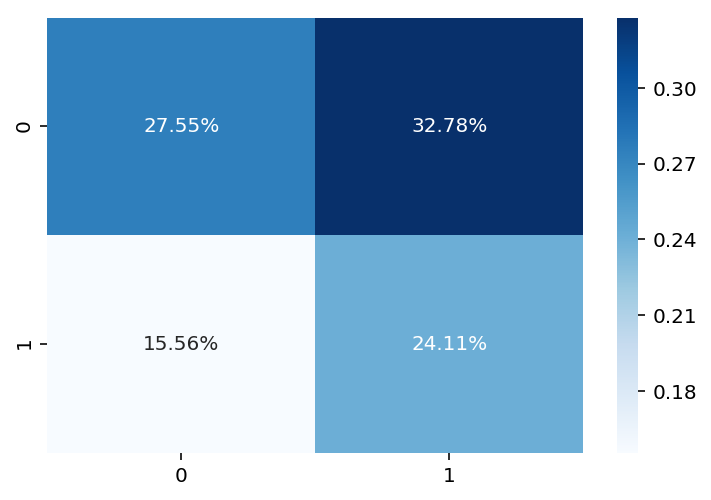

In [124]:
%config InlineBackend.figure_format ='retina'
from sklearn.metrics import confusion_matrix

# predicted = model.predict(X_test)
matrix = confusion_matrix(test_df['label'], test_pred)
sns.heatmap(matrix/np.sum(matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [125]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(test_df['label'], test_pred, average='binary')

(0.42376681614349776, 0.6077170418006431, 0.4993394980184941, None)

In [50]:
# cross-validation on train
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score

X_train = tweet_vectorizer.fit_transform(clean_data_df['clean_tweet'])
Y_train = clean_data_df['label']


# Example of cross-validation
rf = RandomForestClassifier(n_estimators=100)

score = cross_val_score(rf, X_train, Y_train, cv=10, scoring = "accuracy")
print("Score:", score)
print("Mean:", score.mean())a
print("std:", score.std())

Score: [0.63376623 0.62239583 0.6328125  0.63446475 0.62663185 0.61618799
 0.62140992 0.60052219 0.61357702 0.58746736]
Mean: 0.6189235663705311
std: 0.014479517147514106


In [49]:
# test set


(3834,)